In [2]:
import pandas as pd

df = pd.read_csv("Working_df/Actuals_all_enriched.csv")

df['week_start'] = pd.to_datetime(df['week_start'])

# Aggregate weekly total sales
weekly_sales = df.groupby('week_start')['Sum of Invoiced Amount EUR'].sum().asfreq('W-MON')

# Fill any missing weeks with 0
weekly_sales = weekly_sales.fillna(0)

# Preview
print(weekly_sales.head())


C:\Users\danii\AppData\Local\Temp\ipykernel_16340\825352654.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Working_df/Actuals_all_enriched.csv")


week_start
2016-12-26    1.161023e+06
2017-01-02    1.006877e+06
2017-01-09    2.317849e+06
2017-01-16    2.709567e+06
2017-01-23    1.809981e+06
Freq: W-MON, Name: Sum of Invoiced Amount EUR, dtype: float64


In [3]:
print(df.head())

   year  week week_start Customer.Customer Code item_code  \
0  2017    51 2017-12-18                 100000  10009724   
1  2021    14 2021-04-05                 100000  80220916   
2  2017     9 2017-02-27                 100000  80240001   
3  2017    10 2017-03-06                 100000  80240001   
4  2017    13 2017-03-27                 100000  80240001   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty      Country.Country Name  \
0                         0.0                  1.0  United States of America   
1                         0.0                  0.0  United States of America   
2                      1200.0                  1.0  United States of America   
3                      1200.0                  1.0  United States of America   
4                      2400.0                  2.0  United States of America   

      Item.Sales Model item_suffix  ...  is_subscription  is_new_sale  \
0  Production Sub Type         NaN  ...                0            0   
1     

In [2]:
# Ensure datetime index
weekly_sales.index = pd.to_datetime(weekly_sales.index)

# Define cutoff
cutoff_date = pd.to_datetime("2024-09-01")

# Train/Test split
train_series = weekly_sales[weekly_sales.index < cutoff_date]
test_series = weekly_sales[weekly_sales.index >= cutoff_date]


In [3]:
print(weekly_sales.shape)

(419,)


In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Plot the weekly sales
weekly_sales.plot(figsize=(12, 4), title="Weekly Total Sales (EUR)")
plt.ylabel("Sales (€)")
plt.xlabel("Week Start")
plt.show()

# ADF Test
adf_result = adfuller(weekly_sales)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\School\ITU\Coding\Anaconda\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\School\ITU\Coding\Anaconda\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\School\ITU\Coding\Anaconda\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\School\ITU\Coding\Anaconda\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "d:\School\ITU\Codi

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

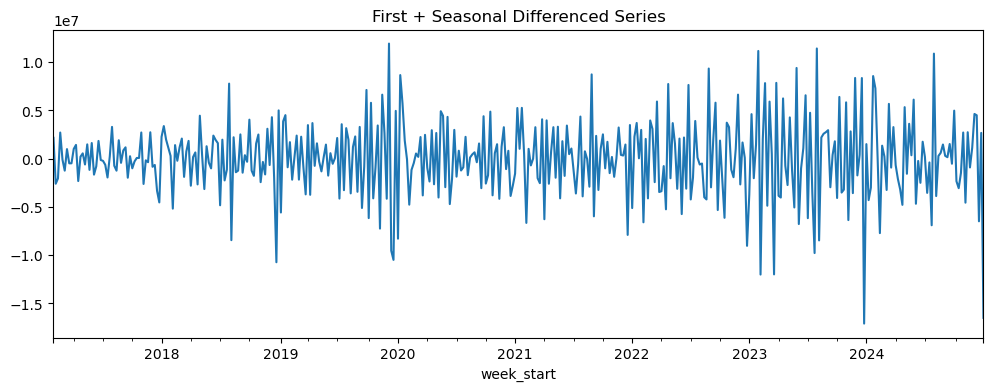

In [ ]:
import matplotlib.pyplot as plt

# Apply first differencing
diff_1 = weekly_sales.diff().dropna()

# Seasonal differencing (4-week seasonality)
diff_1_seasonal = diff_1.diff(4).dropna()

# Plot the result
plt.figure(figsize=(12, 4))
diff_1_seasonal.plot(title="First + Seasonal Differenced Series")
plt.show()


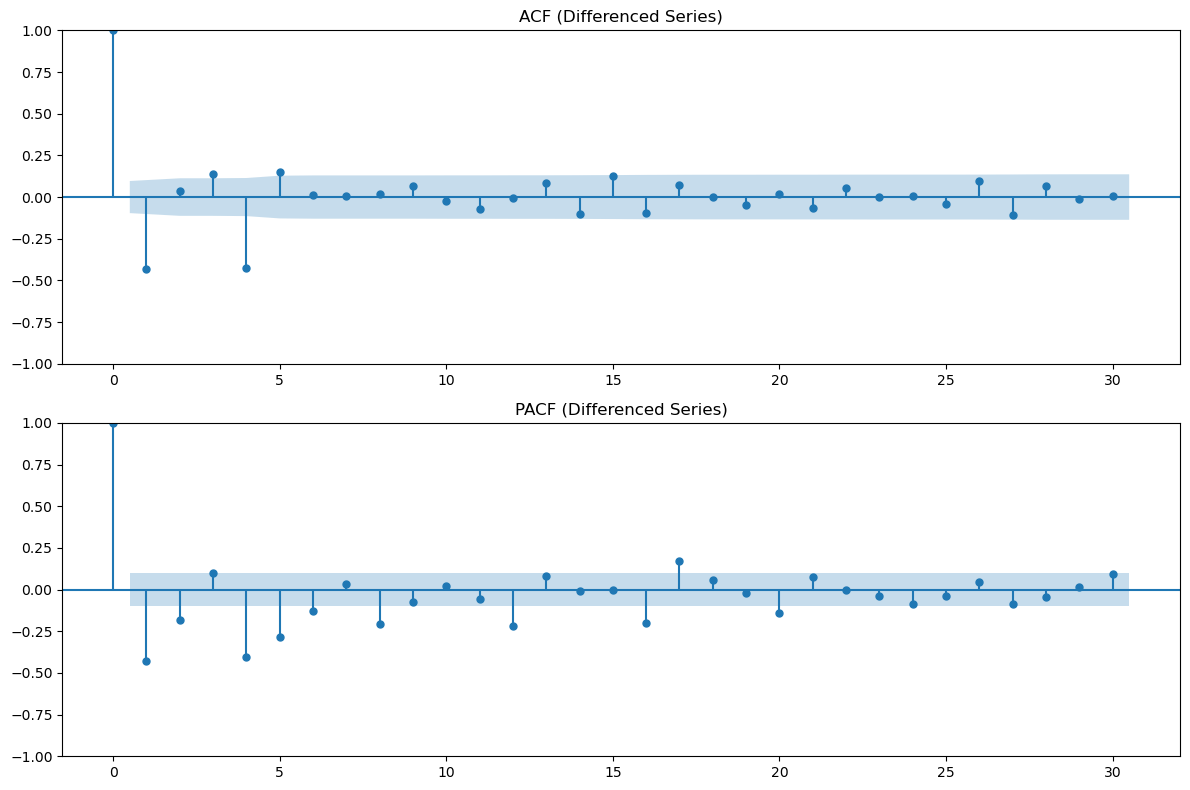

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(diff_1_seasonal, lags=30, ax=axes[0])
axes[0].set_title('ACF (Differenced Series)')

plot_pacf(diff_1_seasonal, lags=30, ax=axes[1])
axes[1].set_title('PACF (Differenced Series)')

plt.tight_layout()
plt.show()


In [ ]:
print(f"Total data points in weekly_sales: {len(weekly_sales)}")
print(f"Total data points after full differencing: {len(diff_1_seasonal)}")


Total data points in weekly_sales: 419
Total data points after full differencing: 414


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_sales,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:         Sum of Invoiced Amount EUR   No. Observations:                  419
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 4)   Log Likelihood               -6670.936
Date:                            Thu, 24 Apr 2025   AIC                          13349.873
Time:                                    14:13:09   BIC                          13365.928
Sample:                                12-26-2016   HQIC                         13356.225
                                     - 12-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1731      0.074      2.344      0.019       0.028       0.318
ma.L1         -0.9893      0.015   

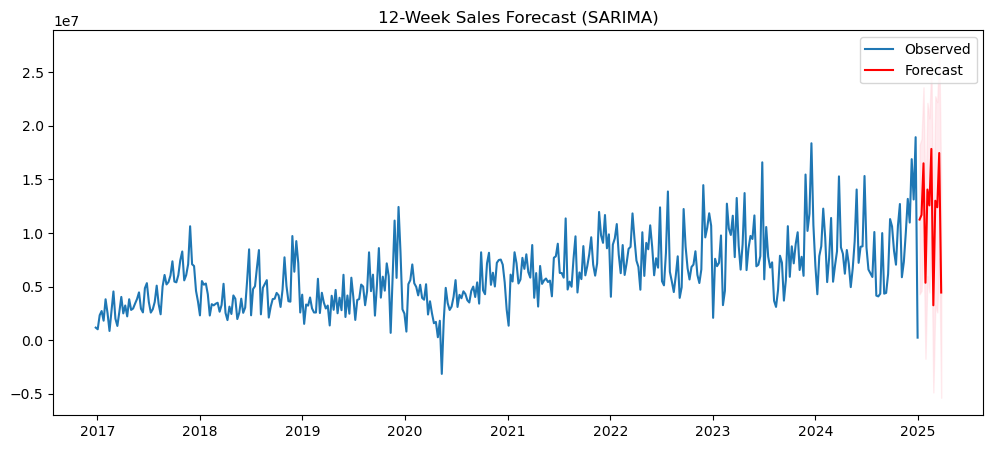

In [ ]:
# Forecast next 12 weeks
forecast = results.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(weekly_sales, label='Observed')
plt.plot(mean_forecast, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("12-Week Sales Forecast (SARIMA)")
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train_series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()


In [ ]:
# Forecast the same number of steps as test period length
n_test_steps = len(test_series)

forecast = results.get_forecast(steps=n_test_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


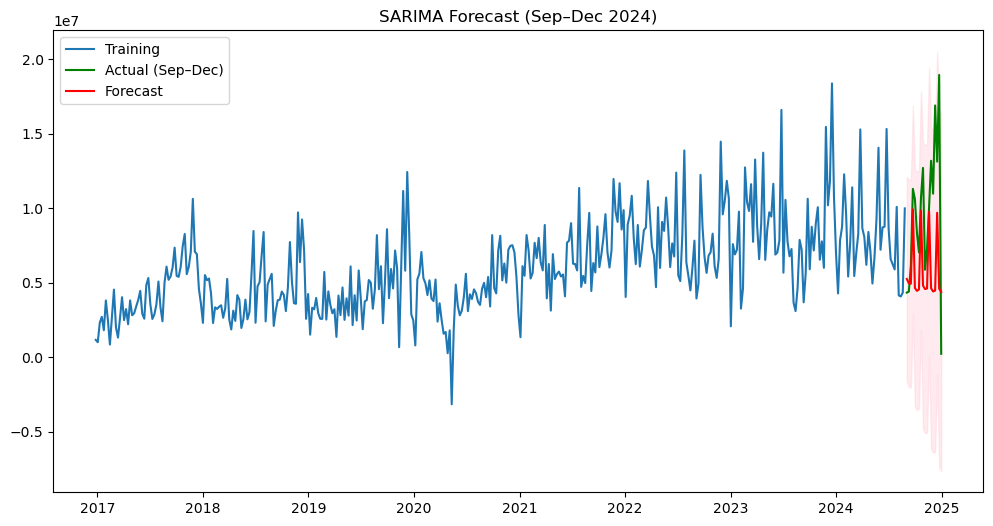

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Training')
plt.plot(test_series, label='Actual (Sep–Dec)', color='green')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title("SARIMA Forecast (Sep–Dec 2024)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test_series, forecast_mean)
mse = mean_squared_error(test_series, forecast_mean)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 4380872.05
RMSE: 5956135.71


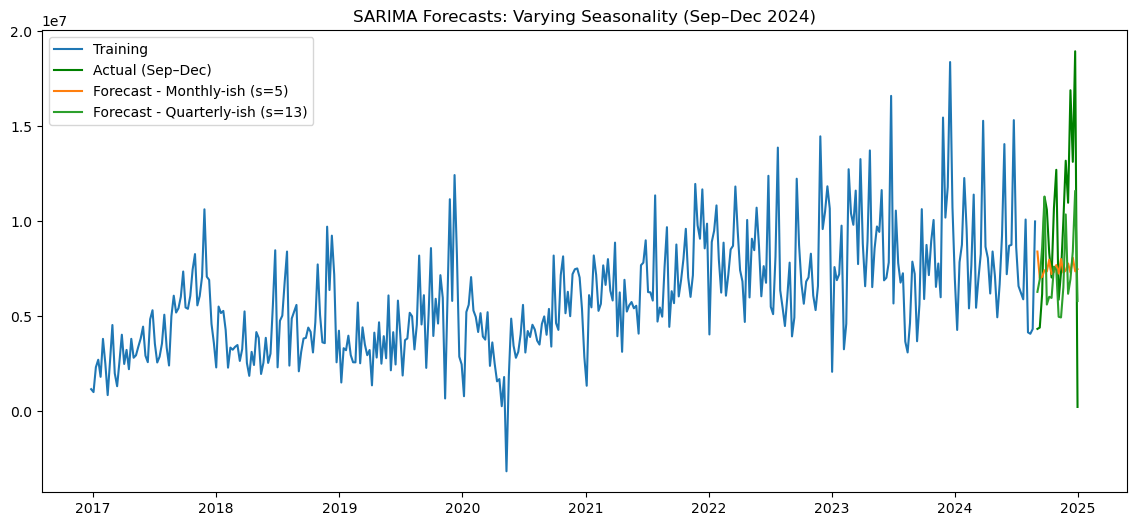

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define the models
model_configs = {
    "Monthly-ish (s=5)": (1, 1, 1, 1, 1, 1, 5),
    "Quarterly-ish (s=13)": (1, 1, 1, 1, 1, 1, 13)
}

forecasts = {}

for label, (p,d,q,P,D,Q,s) in model_configs.items():
    model = SARIMAX(
        train_series,
        order=(p,d,q),
        seasonal_order=(P,D,Q,s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=len(test_series))
    forecasts[label] = forecast.predicted_mean

# Plot forecasts
plt.figure(figsize=(14, 6))
plt.plot(train_series, label='Training')
plt.plot(test_series, label='Actual (Sep–Dec)', color='green')

for label, forecast in forecasts.items():
    plt.plot(forecast, label=f'Forecast - {label}')

plt.title("SARIMA Forecasts: Varying Seasonality (Sep–Dec 2024)")
plt.legend()
plt.show()


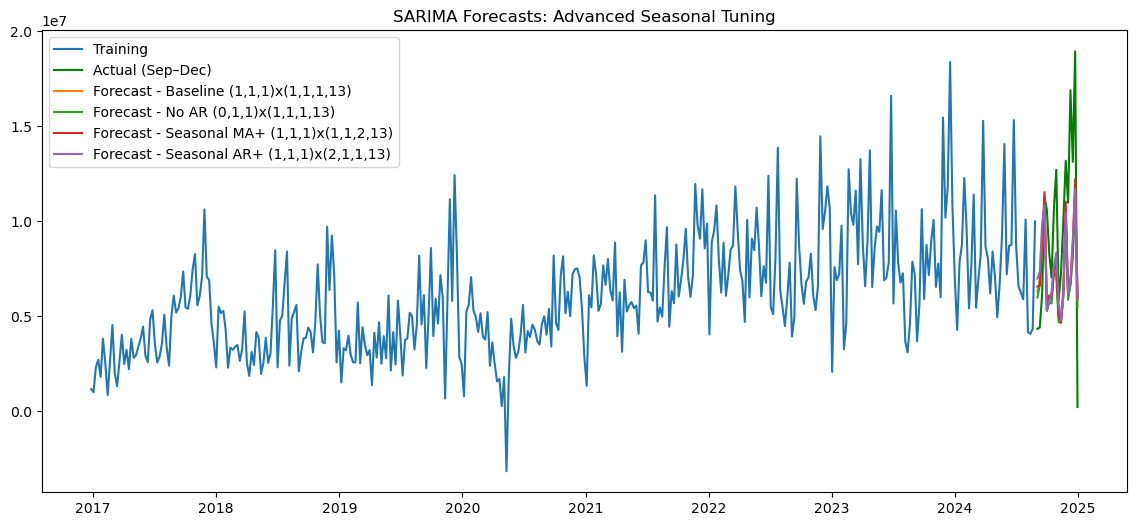

In [ ]:
model_configs = {
    "Baseline (1,1,1)x(1,1,1,13)": ((1,1,1), (1,1,1,13)),
    "No AR (0,1,1)x(1,1,1,13)": ((0,1,1), (1,1,1,13)),
    "Seasonal MA+ (1,1,1)x(1,1,2,13)": ((1,1,1), (1,1,2,13)),
    "Seasonal AR+ (1,1,1)x(2,1,1,13)": ((1,1,1), (2,1,1,13)),
}

forecasts = {}

for label, (order, seasonal_order) in model_configs.items():
    model = SARIMAX(
        train_series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=len(test_series))
    forecasts[label] = forecast.predicted_mean

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train_series, label='Training')
plt.plot(test_series, label='Actual (Sep–Dec)', color='green')

for label, forecast in forecasts.items():
    plt.plot(forecast, label=f'Forecast - {label}')

plt.title("SARIMA Forecasts: Advanced Seasonal Tuning")
plt.legend()
plt.show()


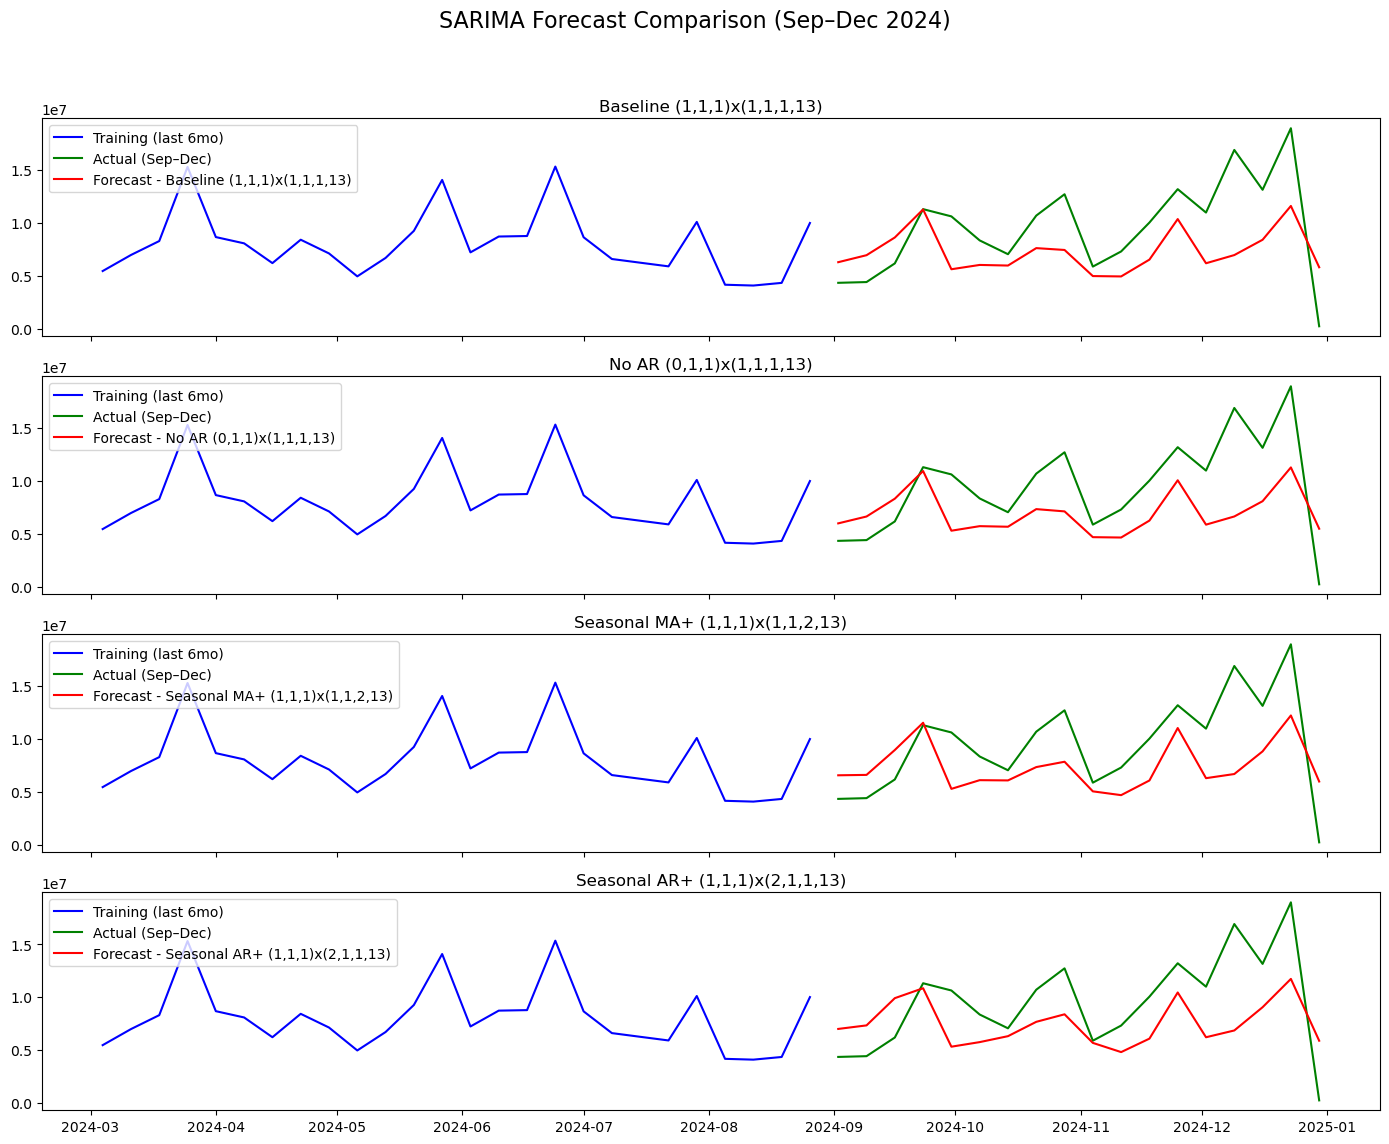

In [ ]:
import matplotlib.pyplot as plt

# Limit training data to last 6 months
recent_train = train_series[train_series.index >= '2024-03-01']

fig, axes = plt.subplots(len(forecasts), 1, figsize=(14, 12), sharex=True)

for i, (label, forecast) in enumerate(forecasts.items()):
    ax = axes[i]
    ax.plot(recent_train, label='Training (last 6mo)', color='blue')
    ax.plot(test_series, label='Actual (Sep–Dec)', color='green')
    ax.plot(forecast, label=f'Forecast - {label}', color='red')
    
    ax.set_title(label)
    ax.legend(loc='upper left')

plt.suptitle("SARIMA Forecast Comparison (Sep–Dec 2024)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {}

for label, forecast in forecasts.items():
    # Align forecast with actual test series (just in case)
    y_true = test_series.loc[forecast.index]
    y_pred = forecast.loc[test_series.index]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    metrics[label] = {'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}

# Display as a DataFrame
import pandas as pd
metrics_df = pd.DataFrame(metrics).T.sort_values(by='RMSE')
print(metrics_df)


                                          MAE          RMSE    MAPE (%)
Seasonal MA+ (1,1,1)x(1,1,2,13)  3.632276e+06  4.329652e+06  174.212477
Baseline (1,1,1)x(1,1,1,13)      3.646747e+06  4.349365e+06  169.845681
Seasonal AR+ (1,1,1)x(2,1,1,13)  3.723875e+06  4.395139e+06  173.192465
No AR (0,1,1)x(1,1,1,13)         3.816996e+06  4.518240e+06  163.219759


In [ ]:
# Grab original forecast and actuals
best_forecast = forecasts["Seasonal MA+ (1,1,1)x(1,1,2,13)"]
y_true = test_series.loc[best_forecast.index]

# Compute scaling factor
scaling_factor = y_true.mean() / best_forecast.mean()
print(f"Scaling factor: {scaling_factor:.3f}")

# Apply scaling
scaled_forecast = best_forecast * scaling_factor


Scaling factor: 1.293


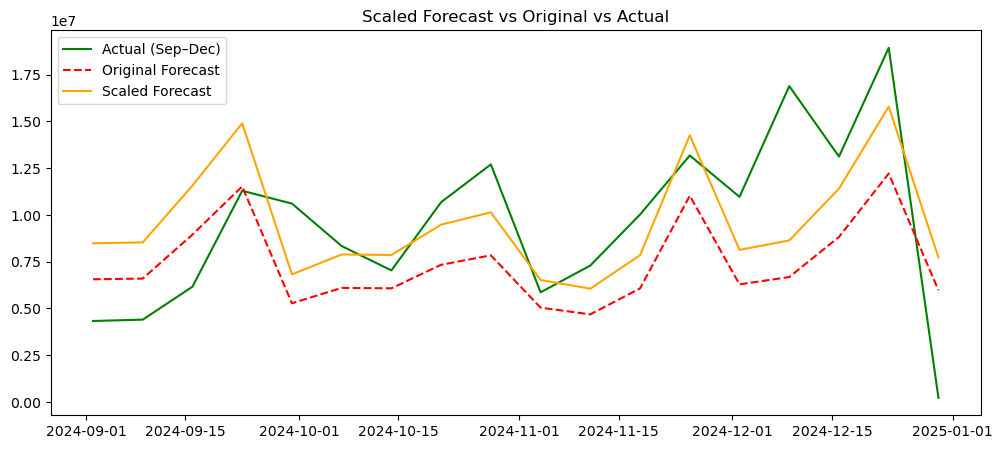

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(test_series, label='Actual (Sep–Dec)', color='green')
plt.plot(best_forecast, label='Original Forecast', color='red', linestyle='--')
plt.plot(scaled_forecast, label='Scaled Forecast', color='orange')
plt.title("Scaled Forecast vs Original vs Actual")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_true, scaled_forecast)
rmse = np.sqrt(mean_squared_error(y_true, scaled_forecast))
mape = np.mean(np.abs((y_true - scaled_forecast) / y_true)) * 100

print(f"Scaled MAE: {mae:,.2f}")
print(f"Scaled RMSE: {rmse:,.2f}")
print(f"Scaled MAPE: {mape:.2f}%")


Scaled MAE: 3,039,477.93
Scaled RMSE: 3,747,751.28
Scaled MAPE: 215.69%


In [ ]:
import numpy as np
import pandas as pd

# Create a progressive scaling array that starts at 1 and grows to the final scaling_factor
n_steps = len(best_forecast)
progressive_factors = np.linspace(1.0, scaling_factor, n_steps)

# Apply progressive scaling
progressively_scaled_forecast = best_forecast.values * progressive_factors
progressively_scaled_forecast = pd.Series(progressively_scaled_forecast, index=best_forecast.index)


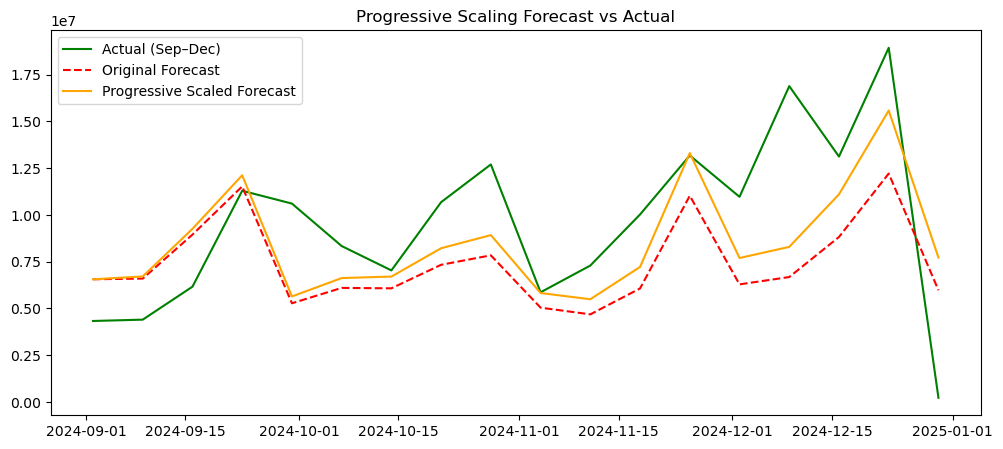

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(test_series, label='Actual (Sep–Dec)', color='green')
plt.plot(best_forecast, label='Original Forecast', linestyle='--', color='red')
plt.plot(progressively_scaled_forecast, label='Progressive Scaled Forecast', color='orange')
plt.title("Progressive Scaling Forecast vs Actual")
plt.legend()
plt.show()


In [ ]:
mae = mean_absolute_error(y_true, progressively_scaled_forecast)
rmse = np.sqrt(mean_squared_error(y_true, progressively_scaled_forecast))
mape = np.mean(np.abs((y_true - progressively_scaled_forecast) / y_true)) * 100

print(f"Progressive MAE: {mae:,.2f}")
print(f"Progressive RMSE: {rmse:,.2f}")
print(f"Progressive MAPE: {mape:.2f}%")


Progressive MAE: 2,845,872.45
Progressive RMSE: 3,620,279.13
Progressive MAPE: 210.05%


Check for overfitting

In [ ]:
cutoff_date = pd.to_datetime("2024-03-01")

train_early = weekly_sales[weekly_sales.index < cutoff_date]
test_early = weekly_sales[(weekly_sales.index >= cutoff_date) & (weekly_sales.index <= '2024-06-30')]


In [ ]:
model = SARIMAX(
    train_early,
    order=(1,1,1),
    seasonal_order=(1,1,2,13),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
forecast_early = results.get_forecast(steps=len(test_early)).predicted_mean


In [ ]:
scaling_factor_early = test_early.mean() / forecast_early.mean()
progressive_factors_early = np.linspace(1.0, scaling_factor_early, len(forecast_early))
scaled_forecast_early = forecast_early.values * progressive_factors_early
scaled_forecast_early = pd.Series(scaled_forecast_early, index=forecast_early.index)


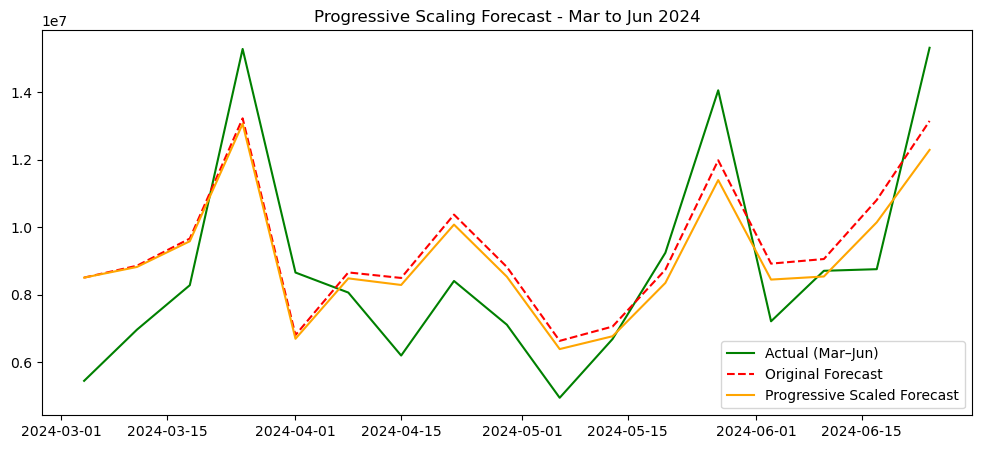

Backtest MAE: 1,582,975.74
Backtest RMSE: 1,803,221.57
Backtest MAPE: 19.32%


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(test_early, label='Actual (Mar–Jun)', color='green')
plt.plot(forecast_early, label='Original Forecast', linestyle='--', color='red')
plt.plot(scaled_forecast_early, label='Progressive Scaled Forecast', color='orange')
plt.title("Progressive Scaling Forecast - Mar to Jun 2024")
plt.legend()
plt.show()

# Error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_early, scaled_forecast_early)
rmse = np.sqrt(mean_squared_error(test_early, scaled_forecast_early))
mape = np.mean(np.abs((test_early - scaled_forecast_early) / test_early)) * 100

print(f"Backtest MAE: {mae:,.2f}")
print(f"Backtest RMSE: {rmse:,.2f}")
print(f"Backtest MAPE: {mape:.2f}%")


Residuals for LSTM

In [ ]:
# Full forecast using Seasonal MA+ SARIMA model
sarima_forecast_full = results.get_prediction(start=weekly_sales.index[0], end=weekly_sales.index[-1]).predicted_mean

# Align with true sales
actual_sales = weekly_sales[sarima_forecast_full.index]
residual_series = actual_sales - sarima_forecast_full


In [ ]:
#save residuals to csv
residual_series.to_csv("Working_df/residuals.csv", index=True, header=True)

In [4]:
#pull residuals  from csv
residual_series = pd.read_csv("Working_df/residuals.csv", index_col=0, parse_dates=True)
residual_series = residual_series.rename(columns={"residuals": "Residuals"})

In [5]:
df['week_start'] = pd.to_datetime(df['week_start'])

# Aggregate to weekly total
weekly_features = df.groupby('week_start').agg({
    'Sum of Invoiced Amount EUR': 'sum',
    'is_expected_renewal_week': 'max',
    'is_sub_renewal': 'sum',
    'weeks_since_last_renewal': 'mean',
    # Add any other columns you'd like to include here
}).asfreq('W-MON').fillna(0)

# Add residuals
weekly_features['residual'] = residual_series


In [6]:
print(weekly_features.head())

            Sum of Invoiced Amount EUR  is_expected_renewal_week  \
week_start                                                         
2016-12-26                1.161023e+06                         1   
2017-01-02                1.006877e+06                         1   
2017-01-09                2.317849e+06                         1   
2017-01-16                2.709567e+06                         1   
2017-01-23                1.809981e+06                         1   

            is_sub_renewal  weeks_since_last_renewal      residual  
week_start                                                          
2016-12-26             903                  0.000000           NaN  
2017-01-02             148                 -0.580000 -1.788875e+05  
2017-01-09             197                 -0.678423  1.178858e+06  
2017-01-16             238                 -0.687232  1.243472e+06  
2017-01-23             223                 -0.640936  6.221289e+04  


In [ ]:
for lag in [1, 2, 3]:
    weekly_features[f'residual_lag_{lag}'] = weekly_features['residual'].shift(lag)


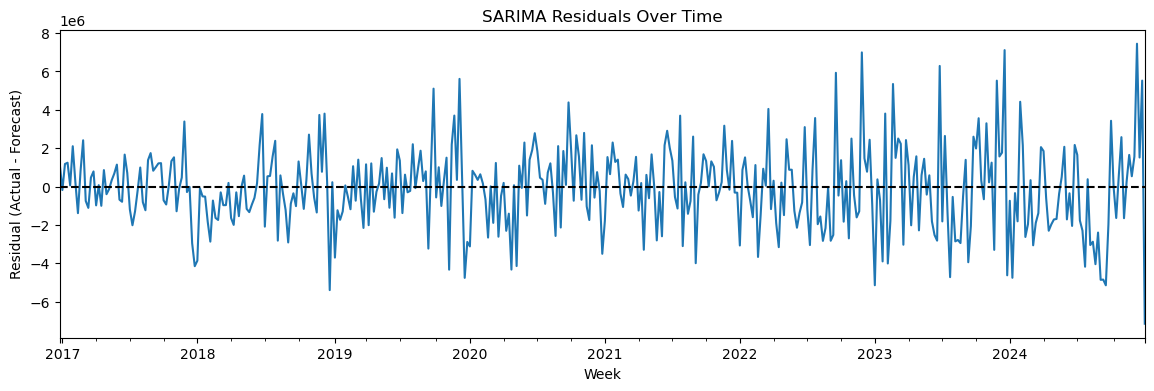

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
residual_series.plot()
plt.title("SARIMA Residuals Over Time")
plt.xlabel("Week")
plt.ylabel("Residual (Actual - Forecast)")
plt.axhline(0, color='black', linestyle='--')
plt.show()


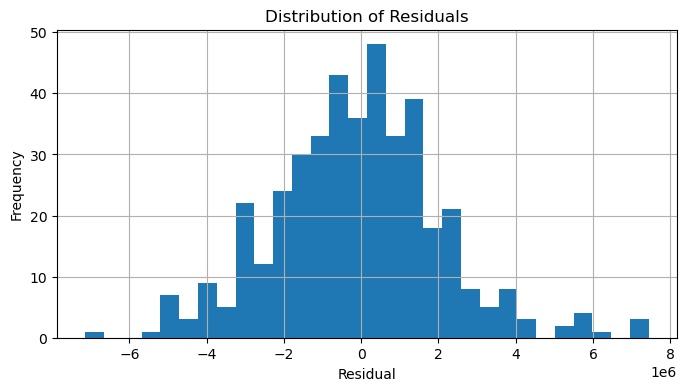

In [ ]:
residual_series.hist(bins=30, figsize=(8, 4))
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


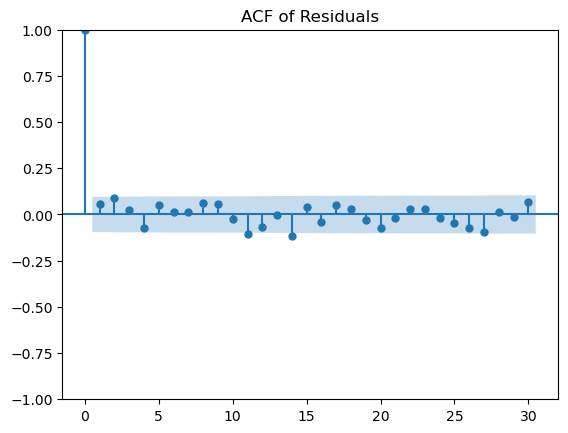

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residual_series.dropna(), lags=30)
plt.title("ACF of Residuals")
plt.show()


In [7]:
import pandas as pd

# Load competitor features CSV
stock_df = pd.read_csv("Working_df/Selected_lagged_features.csv", parse_dates=['Date'])

# Ensure date is weekly aligned (assumed already to be Mondays)
stock_df = stock_df.set_index('Date').asfreq('W-MON')


In [ ]:
"""
weekly_agg = df.groupby('week_start').agg({
    'Sum of Invoiced Amount EUR': 'sum',
    'Sum of Invoiced Qty': 'sum',
    'is_subscription': 'sum',       # Count of subscription-type sales
    'is_renewal': 'sum',            # Count of renewals
    'is_sub_renewal': 'sum'         # Count of subscription renewals
}).asfreq('W-MON').fillna(0)
"""

In [8]:
# Step 1: Add time features before grouping (if not already present)
df['week_start'] = pd.to_datetime(df['week_start'])
df['month'] = df['week_start'].dt.month
df['quarter'] = df['week_start'].dt.quarter
df['is_year_end'] = (df['week'] >= 50).astype(int)

# Step 2: Group and aggregate (preserving calendar fields)
weekly_agg = df.groupby('week_start').agg({
    'Sum of Invoiced Amount EUR': 'sum',
    'Sum of Invoiced Qty': 'sum',
    'is_subscription': 'sum',
    'is_renewal': 'sum',
    'is_sub_renewal': 'sum',
    'week': 'first',
    'month': 'first',
    'quarter': 'first',
    'is_year_end': 'first',
    'year': 'first'
}).asfreq('W-MON').fillna(0)


In [9]:
# Add SARIMA residuals
weekly_agg['sarima_residual'] = residual_series

# Join stock features
combined = weekly_agg.join(stock_df, how='left')

# Drop NaNs due to stock lag alignment
combined = combined.dropna()


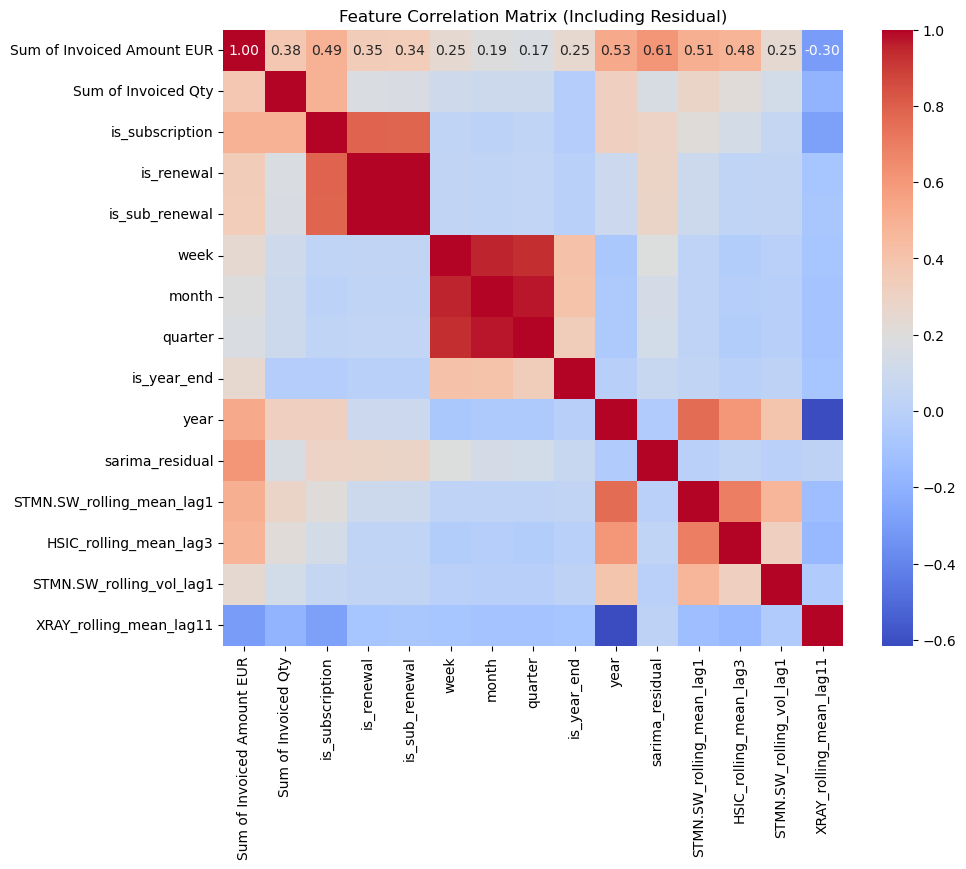

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = combined.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix (Including Residual)")
plt.show()


In [11]:
corr['sarima_residual'].sort_values(ascending=False)


sarima_residual               1.000000
Sum of Invoiced Amount EUR    0.609423
is_subscription               0.299353
is_renewal                    0.289627
is_sub_renewal                0.287027
week                          0.188221
Sum of Invoiced Qty           0.159905
month                         0.138023
quarter                       0.126896
is_year_end                   0.071091
HSIC_rolling_mean_lag3        0.029696
XRAY_rolling_mean_lag11       0.017446
STMN.SW_rolling_vol_lag1      0.002369
STMN.SW_rolling_mean_lag1    -0.002047
year                         -0.045535
Name: sarima_residual, dtype: float64

In [12]:
combined.nunique().sort_values()


is_year_end                     2
quarter                         4
year                            9
month                          12
week                           53
is_renewal                    339
is_sub_renewal                348
is_subscription               356
HSIC_rolling_mean_lag3        400
STMN.SW_rolling_mean_lag1     401
XRAY_rolling_mean_lag11       406
Sum of Invoiced Amount EUR    407
Sum of Invoiced Qty           407
sarima_residual               407
STMN.SW_rolling_vol_lag1      407
dtype: int64

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Separate features and target
X = combined.drop(columns=['sarima_residual'])
y = combined['sarima_residual']

# Initialize and fit scaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Keep for inverse transformation later if needed
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)


In [44]:
print(X.head())

            Sum of Invoiced Amount EUR  Sum of Invoiced Qty  is_subscription  \
week_start                                                                     
2017-03-20                2.626486e+06              2290.16              146   
2017-03-27                4.026268e+06              4210.15             1053   
2017-04-03                2.487044e+06              2814.50              147   
2017-04-10                3.226922e+06              3854.55              147   
2017-04-17                2.211855e+06              2112.86              154   

            is_renewal  is_sub_renewal  week  month  quarter  is_year_end  \
week_start                                                                  
2017-03-20         152             146    12      3        1            0   
2017-03-27        1072            1053    13      3        1            0   
2017-04-03         161             147    14      4        2            0   
2017-04-10         150             146    15      4   

In [14]:
timesteps = 8
X_seq, y_seq = [], []

# Loop over the scaled feature matrix
for i in range(timesteps, len(X_scaled)):
    X_seq.append(X_scaled[i - timesteps:i])   # 8 weeks of features
    y_seq.append(y[i])                         # residual for the next week


C:\Users\danii\AppData\Local\Temp\ipykernel_16340\1843241857.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(y[i])                         # residual for the next week


In [15]:
import numpy as np

X_seq = np.array(X_seq)     # Shape: (samples, timesteps, features)
y_seq = np.array(y_seq)     # Shape: (samples,)


In [16]:
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (399, 8, 14)
y_seq shape: (399,)


In [17]:
split_idx = int(len(X_seq) * 0.8)

X_train = X_seq[:split_idx]
X_test = X_seq[split_idx:]

y_train = y_seq[:split_idx]
y_test = y_seq[split_idx:]


In [18]:
print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)
print("Train y shape:", y_train.shape)
print("Test y shape:", y_test.shape)


Train X shape: (319, 8, 14)
Test X shape: (80, 8, 14)
Train y shape: (319,)
Test y shape: (80,)


In [31]:
"""
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Dropout
from tensorflow.python.keras.optimizers import Adam
"""
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.optimizers import Adam

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.python.keras.optimizers import Adam
'''

# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))  # optional
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # regression output

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
model.summary()


C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
param_grid = {
    'lstm_units': [32, 64],
    'dense_units': [16, 32],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001, 0.0005]
}


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

results = []

for lstm_units in param_grid['lstm_units']:
    for dense_units in param_grid['dense_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                
                # Build model
                model = Sequential()
                model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
                model.add(Dropout(dropout_rate))
                model.add(Dense(dense_units, activation='relu'))
                model.add(Dense(1))  # regression output

                optimizer = Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

                # Train model with early stopping
                history = model.fit(
                    X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
                    verbose=0
                )

                # Evaluate on test set
                loss, mae = model.evaluate(X_test, y_test, verbose=0)

                # Save results
                results.append({
                    'lstm_units': lstm_units,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': lr,
                    'val_mae': min(history.history['val_mae']),
                    'test_mae': mae
                })

                print(f"Trained config: LSTM={lstm_units}, Dense={dense_units}, Dropout={dropout_rate}, LR={lr} → Test MAE={mae:.4f}")


Trained config: LSTM=32, Dense=16, Dropout=0.1, LR=0.001 → Test MAE=2418295.5000
Trained config: LSTM=32, Dense=16, Dropout=0.1, LR=0.0005 → Test MAE=2418295.2500
Trained config: LSTM=32, Dense=16, Dropout=0.2, LR=0.001 → Test MAE=2418295.2500
Trained config: LSTM=32, Dense=16, Dropout=0.2, LR=0.0005 → Test MAE=2418295.2500
Trained config: LSTM=32, Dense=32, Dropout=0.1, LR=0.001 → Test MAE=2418295.2500
Trained config: LSTM=32, Dense=32, Dropout=0.1, LR=0.0005 → Test MAE=2418295.2500
Trained config: LSTM=32, Dense=32, Dropout=0.2, LR=0.001 → Test MAE=2418295.2500
Trained config: LSTM=32, Dense=32, Dropout=0.2, LR=0.0005 → Test MAE=2418295.2500
Trained config: LSTM=64, Dense=16, Dropout=0.1, LR=0.001 → Test MAE=2418295.2500
Trained config: LSTM=64, Dense=16, Dropout=0.1, LR=0.0005 → Test MAE=2418295.2500
Trained config: LSTM=64, Dense=16, Dropout=0.2, LR=0.001 → Test MAE=2418288.2500
Trained config: LSTM=64, Dense=16, Dropout=0.2, LR=0.0005 → Test MAE=2418295.2500
Trained config: LSTM=6

In [22]:
import pandas as pd

results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by='test_mae').head(5)
print(top_results)


    lstm_units  dense_units  dropout_rate  learning_rate      val_mae  \
14          64           32           0.2         0.0010  2000558.000   
10          64           16           0.2         0.0010  2000560.375   
1           32           16           0.1         0.0005  2000565.500   
2           32           16           0.2         0.0010  2000565.625   
3           32           16           0.2         0.0005  2000565.500   

      test_mae  
14  2418283.25  
10  2418288.25  
1   2418295.25  
2   2418295.25  
3   2418295.25  


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


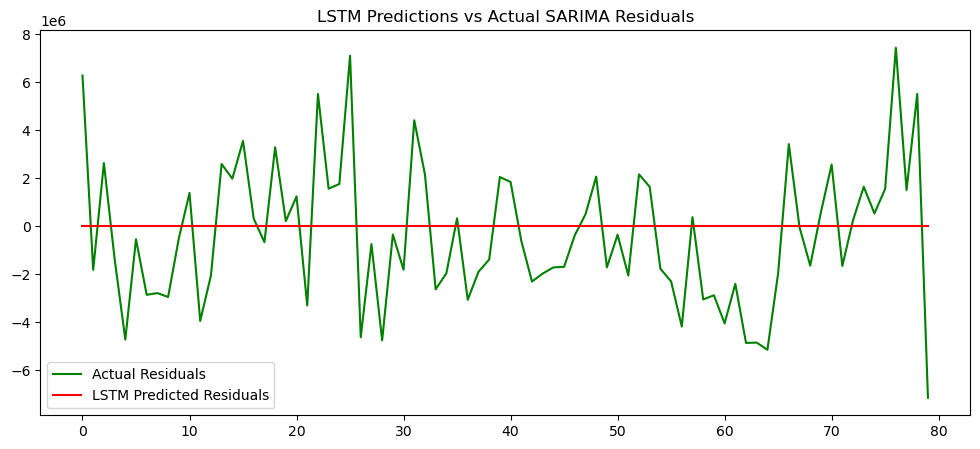

In [23]:
# Predict on test set
y_pred = model.predict(X_test)

# Plot predictions vs actual residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Residuals', color='green')
plt.plot(y_pred.flatten(), label='LSTM Predicted Residuals', color='red')
plt.title("LSTM Predictions vs Actual SARIMA Residuals")
plt.legend()
plt.show()


In [46]:
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()


In [52]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.optimizers import Adam
from keras.api.callbacks import EarlyStopping

# Updated model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # regression output

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train with early stopping
history = model.fit(
    X_train, y_train_scaled,  # use scaled target
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)


C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.9639 - mae: 0.7590 - val_loss: 1.5896 - val_mae: 1.0322
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8890 - mae: 0.7199 - val_loss: 1.5781 - val_mae: 1.0295
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.7447 - mae: 0.6732 - val_loss: 1.5705 - val_mae: 1.0267
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9408 - mae: 0.7531 - val_loss: 1.5750 - val_mae: 1.0300
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.8987 - mae: 0.7383 - val_loss: 1.5970 - val_mae: 1.0396
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.8614 - mae: 0.7234 - val_loss: 1.5833 - val_mae: 1.0369
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.8072 - mae: 0.6870 - val_loss: 1.6005 - val_mae: 1.0427
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.8412 - mae: 0.7190 - val_loss: 1.5961 - val_mae: 1.0429
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.8014 - mae:

In [55]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)  # back to EUR


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


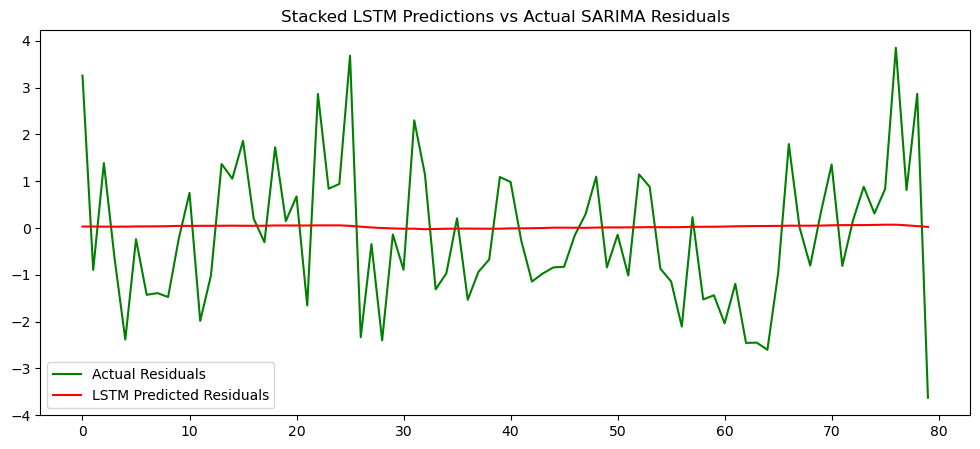

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Residuals', color='green')
plt.plot(y_pred.flatten(), label='LSTM Predicted Residuals', color='red')
plt.title("Stacked LSTM Predictions vs Actual SARIMA Residuals")
plt.legend()
plt.show()


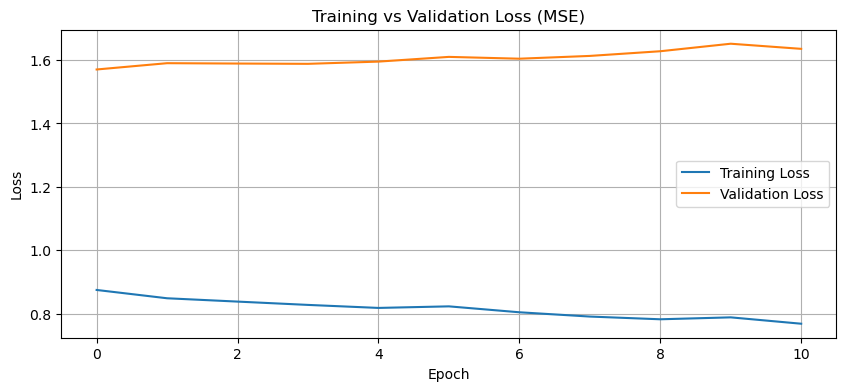

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


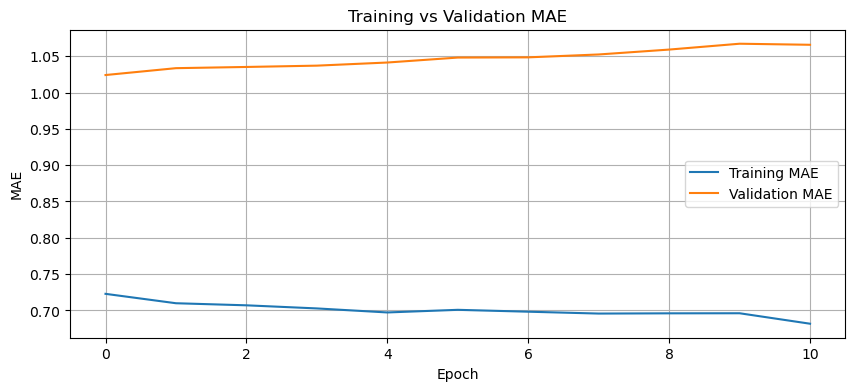

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
